In [1]:
import pandas as pd

In [2]:
data=pd.read_csv("conjoint_data.csv")
data

,resp,task,choice,brand,ad,price
0,1,1,1,N,Yes,28
1,1,1,0,H,Yes,16
2,1,1,0,P,Yes,16
3,1,2,0,N,Yes,32
4,1,2,1,P,Yes,16
...,...,...,...,...,...,...
2995,100,9,1,H,No,12
2996,100,9,0,P,Yes,8
2997,100,10,0,N,Yes,28
2998,100,10,0,H,No,24


In [ ]:
import pandas as pd
X = pd.get_dummies(data, columns=['brand', 'ad'], drop_first=True)
X = X.sort_values(['resp', 'task']).copy()
X['alternative'] = X.groupby(['resp', 'task']).cumcount()
X = X.set_index(['resp', 'task', 'alternative'])
X

choice  price  brand_N  brand_P  ad_Yes
resp task alternative                                         
1    1    0                 1     28     True    False    True
          1                 0     16    False    False    True
          2                 0     16    False     True    True
     2    0                 0     32     True    False    True
          1                 1     16    False     True    True
...                       ...    ...      ...      ...     ...
100  9    1                 1     12    False    False   False
          2                 0      8    False     True    True
     10   0                 0     28     True    False    True
          1                 0     24    False    False   False
          2                 1     16    False    False   False

[3000 rows x 5 columns]

In [4]:
import numpy as np

def mnl_log_likelihood(beta, X, y):
    """
    beta: 參數向量 (K,)
    X:     設計矩陣，形狀為 (n_obs, K)
    y:     choice 向量，形狀為 (n_obs,) 為 0/1 結果
    """
    # reshape：每組 3 個選項一組（假設每個 respondent-task 有 3 選項）
    n_choices = 3
    X_reshaped = X.reshape(-1, n_choices, X.shape[1])
    y_reshaped = y.reshape(-1, n_choices)

    # 效用與機率
    utilities = X_reshaped @ beta
    exp_util = np.exp(utilities)
    probs = exp_util / exp_util.sum(axis=1, keepdims=True)

    # 將選中的那一項的機率取出，然後取 log 相加
    chosen_probs = (probs * y_reshaped).sum(axis=1)
    log_lik = np.sum(np.log(chosen_probs))

    return -log_lik  # 若要配合 minimize，需回傳負值

In [5]:
from scipy.optimize import minimize
import numpy as np

def neg_log_likelihood(beta, X, y):
    return mnl_log_likelihood(beta, X, y)

beta0 = np.zeros(4)

X_np = X[["brand_N", "brand_P", "ad_Yes", "price"]].astype(float).values
y_np = X["choice"].values

result = minimize(neg_log_likelihood, beta0, args=(X_np, y_np), method='BFGS')

mle = result.x

hessian_inv = result.hess_inv
se = np.sqrt(np.diag(hessian_inv))

z = 1.96
ci_lower = mle - z * se
ci_upper = mle + z * se

summary = pd.DataFrame({
    "Parameter": ["Netflix", "Prime", "Ads", "Price"],
    "Estimate": mle,
    "Std. Error": se,
    "95% CI Lower": ci_lower,
    "95% CI Upper": ci_upper
})
summary

,Parameter,Estimate,Std. Error,95% CI Lower,95% CI Upper
0,Netflix,0.941195,0.114003,0.717748,1.164642
1,Prime,0.501616,0.120829,0.264791,0.738441
2,Ads,-0.731994,0.088553,-0.905558,-0.558430
3,Price,-0.099480,0.006357,-0.111941,-0.087020


In [6]:
def mnl_log_posterior(beta, X, y):
    # Flat prior: log-prior is constant, so posterior ∝ likelihood
    return -mnl_log_likelihood(beta, X, y)

def metropolis_hastings(log_posterior, initial, steps, proposal_cov, X, y):
    n_params = len(initial)
    samples = np.zeros((steps, n_params))
    current = initial.copy()
    current_log_post = log_posterior(current, X, y)
    accept_count = 0

    for i in range(steps):
        proposal = np.random.multivariate_normal(current, proposal_cov)
        proposal_log_post = log_posterior(proposal, X, y)
        log_accept_ratio = proposal_log_post - current_log_post

        if np.log(np.random.rand()) < log_accept_ratio:
            current = proposal
            current_log_post = proposal_log_post
            accept_count += 1

        samples[i] = current

    acceptance_rate = accept_count / steps
    return samples, acceptance_rate

# Use MLE covariance as proposal covariance, scaled for better mixing
proposal_cov = hessian_inv * 2.0

mcmc_steps = 11000
initial_beta = mle

samples, acc_rate = metropolis_hastings(
    mnl_log_posterior, initial_beta, mcmc_steps, proposal_cov, X_np, y_np
)

# Discard burn-in
mcmc_samples = samples[1000:]

print(f"Acceptance rate: {acc_rate:.3f}")

Acceptance rate: 0.217


In [7]:
import numpy as np

# 修正版：加上 log prior 的 log posterior
def mnl_log_posterior(beta, X, y):
    log_lik = -mnl_log_likelihood(beta, X, y)
    # prior: beta[:3] ~ N(0, 5^2), beta[3] ~ N(0, 1^2)
    log_prior = np.sum(-0.5 * (beta[:3]**2) / 25) + (-0.5 * (beta[3]**2))
    return log_lik + log_prior

# 修正版：使用固定 proposal covariance（不依賴 Hessian）
proposal_cov = np.diag([0.05, 0.05, 0.05, 0.005]) ** 2

# MCMC sampler
def metropolis_hastings(log_posterior, initial, steps, proposal_cov, X, y):
    n_params = len(initial)
    samples = np.zeros((steps, n_params))
    current = initial.copy()
    current_log_post = log_posterior(current, X, y)
    accept_count = 0

    for i in range(steps):
        proposal = np.random.multivariate_normal(current, proposal_cov)
        proposal_log_post = log_posterior(proposal, X, y)
        log_accept_ratio = proposal_log_post - current_log_post

        if np.log(np.random.rand()) < log_accept_ratio:
            current = proposal
            current_log_post = proposal_log_post
            accept_count += 1

        samples[i] = current

    acceptance_rate = accept_count / steps
    return samples, acceptance_rate

# 假設你已經有 initial_beta = mle, X_np, y_np 準備好
mcmc_steps = 11000
samples, acc_rate = metropolis_hastings(
    mnl_log_posterior, initial_beta, mcmc_steps, proposal_cov, X_np, y_np
)

# Burn-in
mcmc_samples = samples[1000:]

print(f"Acceptance rate: {acc_rate:.3f}")

Acceptance rate: 0.565


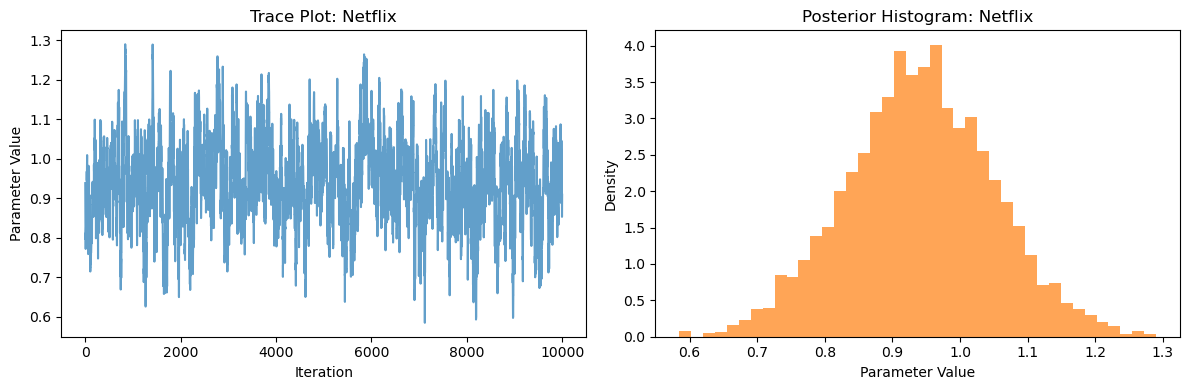

In [10]:
import matplotlib.pyplot as plt

# Choose a parameter index to visualize, e.g., 0 for "Netflix"
param_idx = 0
param_name = ["Netflix", "Prime", "Ads", "Price"][param_idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Trace plot
axes[0].plot(mcmc_samples[:, param_idx], color='tab:blue', alpha=0.7)
axes[0].set_title(f"Trace Plot: {param_name}")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Parameter Value")

# Histogram of posterior
axes[1].hist(mcmc_samples[:, param_idx], bins=40, color='tab:orange', alpha=0.7, density=True)
axes[1].set_title(f"Posterior Histogram: {param_name}")
axes[1].set_xlabel("Parameter Value")
axes[1].set_ylabel("Density")

plt.tight_layout()
plt.show()

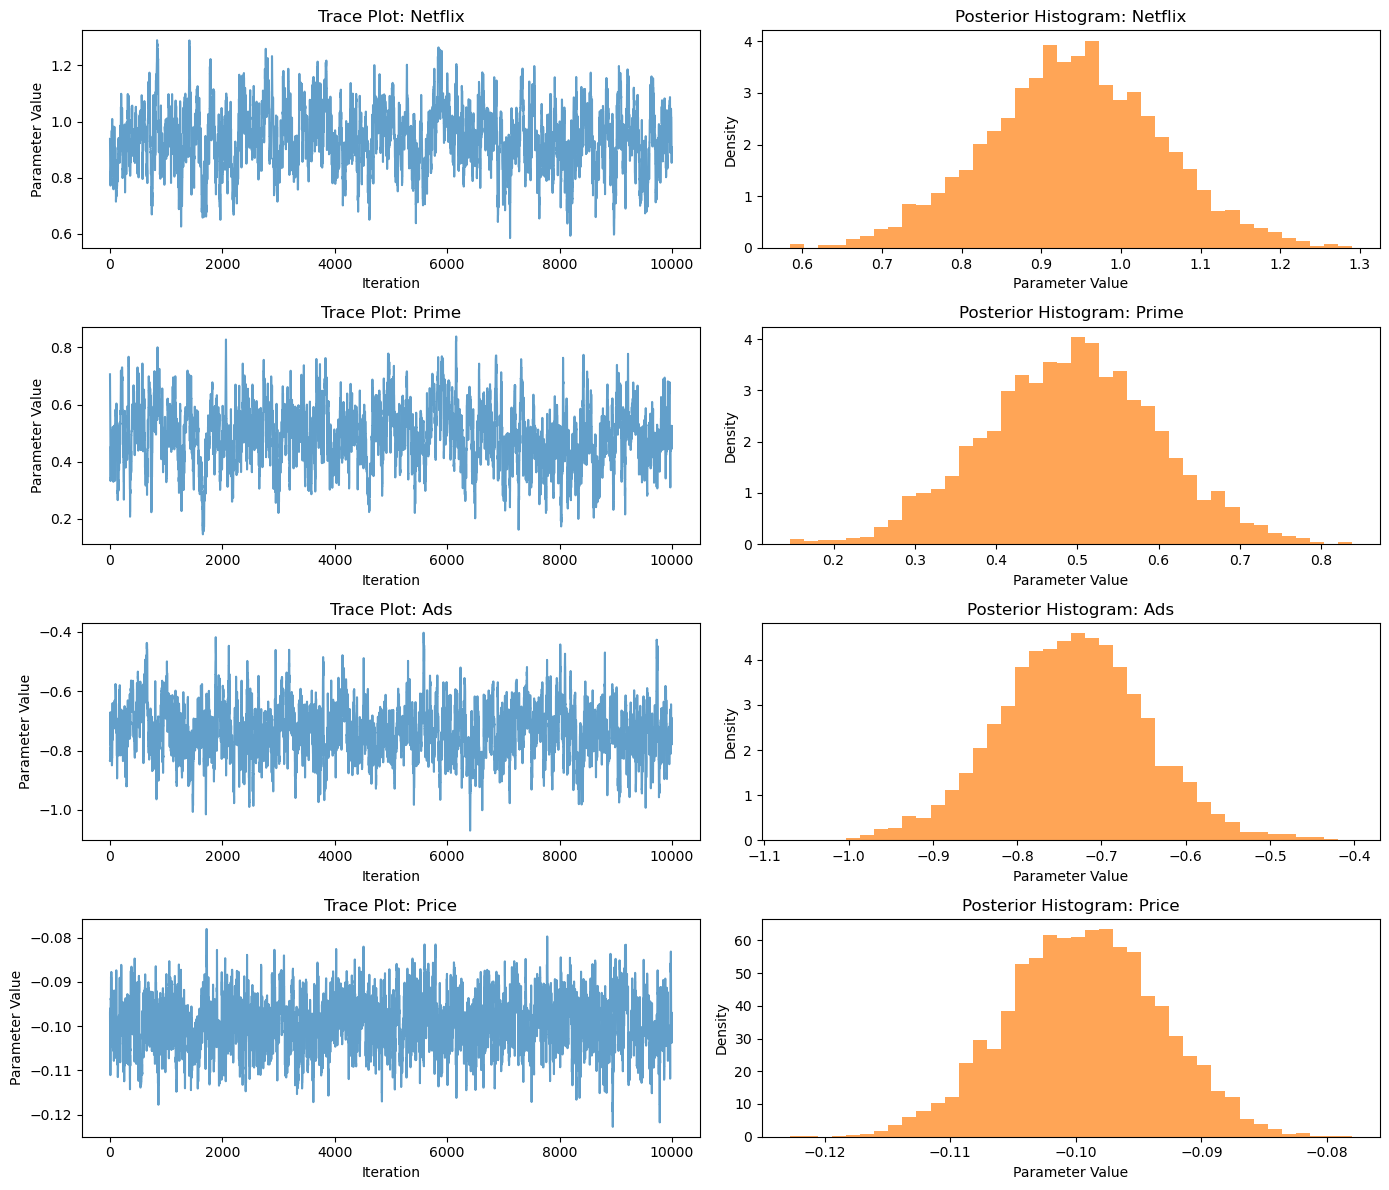

In [11]:
import matplotlib.pyplot as plt

param_names = ["Netflix", "Prime", "Ads", "Price"]

fig, axes = plt.subplots(4, 2, figsize=(14, 12))

for i, name in enumerate(param_names):
    # Trace plot
    axes[i, 0].plot(mcmc_samples[:, i], color='tab:blue', alpha=0.7)
    axes[i, 0].set_title(f"Trace Plot: {name}")
    axes[i, 0].set_xlabel("Iteration")
    axes[i, 0].set_ylabel("Parameter Value")
    
    # Posterior histogram
    axes[i, 1].hist(mcmc_samples[:, i], bins=40, color='tab:orange', alpha=0.7, density=True)
    axes[i, 1].set_title(f"Posterior Histogram: {name}")
    axes[i, 1].set_xlabel("Parameter Value")
    axes[i, 1].set_ylabel("Density")

plt.tight_layout()
plt.show()

In [13]:
# Posterior summaries
posterior_means = mcmc_samples.mean(axis=0)
posterior_stds = mcmc_samples.std(axis=0)
posterior_ci_lower = np.percentile(mcmc_samples, 2.5, axis=0)
posterior_ci_upper = np.percentile(mcmc_samples, 97.5, axis=0)

bayes_summary = pd.DataFrame({
    "Parameter": param_names,
    "Posterior Mean": posterior_means,
    "Posterior Std": posterior_stds,
    "95% CrI Lower": posterior_ci_lower,
    "95% CrI Upper": posterior_ci_upper,
    "MLE": summary["Estimate"].values,
    "MLE Std. Error": summary["Std. Error"].values,
    "MLE 95% CI Lower": summary["95% CI Lower"].values,
    "MLE 95% CI Upper": summary["95% CI Upper"].values
})

bayes_summary

,Parameter,Posterior Mean,Posterior Std,95% CrI Lower,95% CrI Upper,MLE,MLE Std. Error,MLE 95% CI Lower,MLE 95% CI Upper
0,Netflix,0.940487,0.108677,0.726699,1.158957,0.941195,0.114003,0.717748,1.164642
1,Prime,0.491491,0.106370,0.285960,0.698473,0.501616,0.120829,0.264791,0.738441
2,Ads,-0.734662,0.088522,-0.912235,-0.558810,-0.731994,0.088553,-0.905558,-0.558430
3,Price,-0.099388,0.006069,-0.111367,-0.087678,-0.099480,0.006357,-0.111941,-0.087020


In [ ]:
# Discussion on parameter estimates

# 1. What do you observe about the parameter estimates?
# The parameter estimates (both MLE and Bayesian posterior means) for Netflix, Prime, Ads, and Price are all statistically significant, as their 95% confidence/credible intervals do not include zero. The estimates are:
display(bayes_summary)

# 2. What does β_Netflix > β_Prime mean?
# This means that, holding other factors constant, the utility (preference) for Netflix is higher than for Prime. In other words, respondents are more likely to choose Netflix over Prime, all else being equal.

# 3. Does it make sense that β_price is negative?
# Yes, it makes sense. A negative price coefficient indicates that as the price increases, the probability of choosing that option decreases, which aligns with typical consumer behavior (higher prices reduce demand).